In [45]:
import numpy as np
import torch
from transformers import BertForSequenceClassification, BertTokenizer,BertModel,BertConfig, AutoTokenizer
from torch.utils.data import DataLoader
import torch.optim as optim
from datasets import load_dataset
from transformers import glue_compute_metrics, glue_convert_examples_to_features

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from BERTAdapterNico import Adapter, BERTAdapter


#lr =[3e-5, 3e-4, 3e-3]
#batch_size = 32
#epochs = 3
#adapter_size = [8,64,256]

torch.cuda.empty_cache()

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
#model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
BertConfig = BertConfig.from_pretrained('bert-base-uncased')
model = BERTAdapter(BertConfig,256)
dataset = load_dataset("glue","mrpc")


# Afficher les informations sur le jeu de données
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})


In [46]:
#prepare data

dataset = dataset.map(lambda e: tokenizer(e['sentence1'], truncation=True, padding='max_length'), batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset = dataset.rename_column("label", "labels")



traindataloader = DataLoader(dataset["train"], batch_size=32)
validationdataloader = DataLoader(dataset["validation"], batch_size=32)
testdataloader = DataLoader(dataset["test"], batch_size=32)


In [47]:
#parameters
optimizer = optim.Adam(model.parameters(),lr = 3e-5)
epochs = 3

In [48]:
#training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses=[]
val_losses=[]
val_accuracy =[]
train_accuracy =[]
test_accuracy = []

bar_progress = tqdm(range(epochs))
for epoch in range(epochs):
    model.train()
    total_loss = 0
    l = []
    total = 0
    correct = 0
    for batch in traindataloader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        model.eval()
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            total += batch["labels"].size(0)
            correct += (predictions==batch["labels"]).sum().item()

    l = np.array(l)
    train_losses.append(l.mean())
    train_accuracy.append(correct/total)

    l = []
    total = 0
    correct = 0
    model.eval()
    for batch in validationdataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            l.append(loss.item())
            predictions = torch.argmax(outputs.logits, dim=-1)
            total += batch["labels"].size(0)
            correct += (predictions==batch["labels"]).sum().item()
    l = np.array(l)
    val_losses.append(l.mean())
    val_accuracy.append(correct/total)
    bar_progress.update(1)


  0%|          | 0/3 [00:00<?, ?it/s]

TypeError: BERTAdapter.forward() got an unexpected keyword argument 'labels'

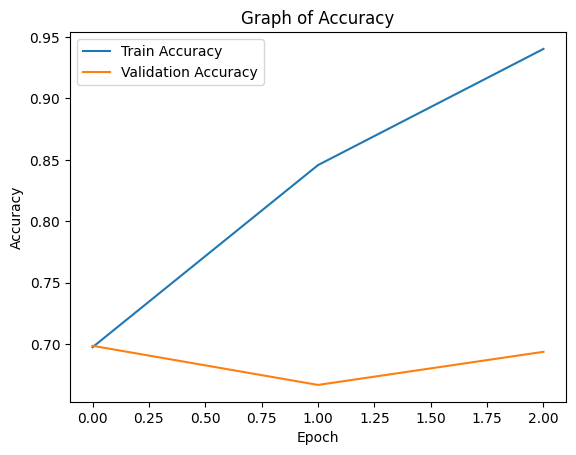

In [32]:
plt.plot(train_accuracy,label='Train Accuracy')
plt.plot(val_accuracy,label='Validation Accuracy')
plt.title('Graph of Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


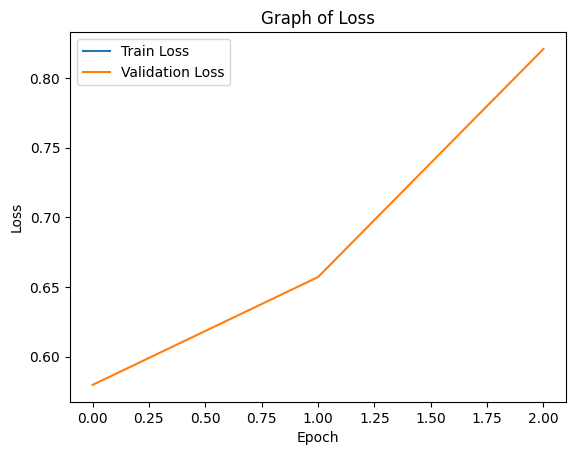

In [34]:
plt.plot(train_losses,label='Train Loss')
plt.plot(val_losses,label='Validation Loss')
        
plt.title('Graph of Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [35]:
test_accuracy = []
total = 0
correct = 0
for batch in testdataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        total += batch["labels"].size(0)
        correct += (predictions==batch["labels"]).sum().item()
    test_accuracy.append(correct/total)
        
print("The Accuracy on the test dataset :",test_accuracy)

The Accuracy on the test dataset : [0.75, 0.71875, 0.6875, 0.6796875, 0.675, 0.6666666666666666, 0.65625, 0.640625, 0.6354166666666666, 0.640625, 0.6505681818181818, 0.6536458333333334, 0.6514423076923077, 0.6517857142857143, 0.65, 0.654296875, 0.6525735294117647, 0.6545138888888888, 0.6644736842105263, 0.6703125, 0.6711309523809523, 0.6732954545454546, 0.6684782608695652, 0.671875, 0.67, 0.6670673076923077, 0.6678240740740741, 0.6640625, 0.6637931034482759, 0.665625, 0.6683467741935484, 0.66796875, 0.665719696969697, 0.6691176470588235, 0.6696428571428571, 0.6666666666666666, 0.6646959459459459, 0.6669407894736842, 0.6690705128205128, 0.66875, 0.6699695121951219, 0.6696428571428571, 0.6686046511627907, 0.6690340909090909, 0.6659722222222222, 0.6657608695652174, 0.6662234042553191, 0.666015625, 0.6670918367346939, 0.6675, 0.6672794117647058, 0.6676682692307693, 0.6650943396226415, 0.6660869565217391]


In [36]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element